# Biomarker-Based Prediction of Pancreatic Cancer

<div style="background-color: #800080; padding: 10px;">PROJECT DESCRIPTION</div>

We want to predict pancreatic ductal adenocarcinoma (PDAC) using a biomarker panel (LYVE1, REG1A, REG1B, and TFF1) tested on urine samples and plasma CA19_9. This type of cancer is one of the deadliest due to its typical late onset of symotpoms at later stages of the disease. While it is ranked 11th in incidence by the NIH, it is ranked 4th in deaths ([Cancer Stat Facts: Common Cancer Sites](https://seer.cancer.gov/statfacts/html/common.html)). For that reason, a test based on biomarkers could facilitate early detection and help save lives.

<div style="background-color: #800080; padding: 10px;">DATA DESCRIPTION</div>

**Citation**: Debernardi, S. et al. (2020). A combination of urinary biomarker panel and PancRISK score for earlier detection of pancreatic cancer: A case–control study. PLoS Medicine, 17(12), e1003489. [https://doi.org/10.1371/journal.pmed.1003489](https://doi.org/10.1371/journal.pmed.1003489)


Samples: Urine (n = 590)

Classes:  
1 = Controls: 183  
2 = Benign, non-cancerous hepatobiliary diseases: 208   
3 = Pancreatic cancer (PDAC): 199  


<div style="background-color: #800080; padding: 10px;">NOTEBOOK SETUP</div>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
DATA = 'data/Debernardi_et_al_2020.csv'

In [3]:
data = pd.read_csv(DATA)

<div style="background-color: #800080; padding: 10px;">DATA EXPLORATION</div>

In [4]:
print(f'The dataset contains {data.shape[0]} samples and {data.shape[1]} features.')

The dataset contains 590 samples and 14 features.


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,590.0,59.079661,13.109520,26.000000,50.000000,60.000000,69.000000,89.000000
diagnosis,590.0,2.027119,0.804873,1.000000,1.000000,2.000000,3.000000,3.000000
plasma_CA19_9,350.0,654.002944,2430.317642,0.000000,8.000000,26.500000,294.000000,31000.000000
creatinine,590.0,0.855383,0.639028,0.056550,0.373230,0.723840,1.139482,4.116840
LYVE1,590.0,3.063530,3.438796,0.000129,0.167179,1.649862,5.205037,23.890323
REG1B,590.0,111.774090,196.267110,0.001104,10.757216,34.303353,122.741013,1403.897600
TFF1,590.0,597.868722,1010.477245,0.005293,43.961000,259.873974,742.736000,13344.300000
REG1A,306.0,735.281222,1477.247724,0.000000,80.692000,208.538500,649.000000,13200.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [7]:
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


These are the columns in the dataframe:

- **age**: (numeric, but can be made categorical)
- **sex**: (categorical: "F", "M")
- **stage**: Stage of the cancer (categorical: "I", "IA", "IB", "II", "IIA", "IIB", "III", "IV")
- **benign_sample_diagnosis**: Diagnosis for benign condition (categorical: list of non-cancerous diseases)
- **plasma_CA19_9**: Biomarker (numeric)
- **creatinine**: Biomarker (numeric)
- **LYVE1**: Biomarker (numeric)
- **REG1B**: Biomarker (numeric)
- **TFF1**: Biomarker (numeric)
- **REG1A**: Biomarker (numeric)
- **diagnosis**: Cancer or no cancer (categorical: "0", "1")


The target variable ('diagnosis') is already in a numeric format. We will need to encode 'sex' and 'age'. 

The stage and benign_sample_diagnosis features are missing values. This is because 1) cancer stages are only relevant to patients with a cancer diagnosis, and 2) benign sample diagnosis is only relevant to patients who received a different diagnosis to pancreatic cancer.

Two of the biomarker features (plasma_CA19_9 and REG1A) have missing values. This is because the study only included these assays from 350 patients.

In [8]:

pd.DataFrame({'Diagnosis': ['Benign', 'PDAC', 'Controls'],
              'Code': data['diagnosis'].value_counts().index,
              'Samples': data['diagnosis'].value_counts().values}).sort_values('Code') \
  .set_index('Code')#.reset_index(drop=True).rename_axis(index=None)


,Diagnosis,Samples
Code,,
1,Controls,183
2,Benign,208
3,PDAC,199


<div style="background-color: #800080; padding: 10px;">DATA CLEANING</div>

In [9]:
print('PERCENT OF MISSING DATA PER FEATURE:\n{}'.format((data.isna().sum()/data.shape[0])*100))

PERCENT OF MISSING DATA PER FEATURE:
sample_id                   0.000000
patient_cohort              0.000000
sample_origin               0.000000
age                         0.000000
sex                         0.000000
diagnosis                   0.000000
stage                      66.271186
benign_sample_diagnosis    64.745763
plasma_CA19_9              40.677966
creatinine                  0.000000
LYVE1                       0.000000
REG1B                       0.000000
TFF1                        0.000000
REG1A                      48.135593
dtype: float64


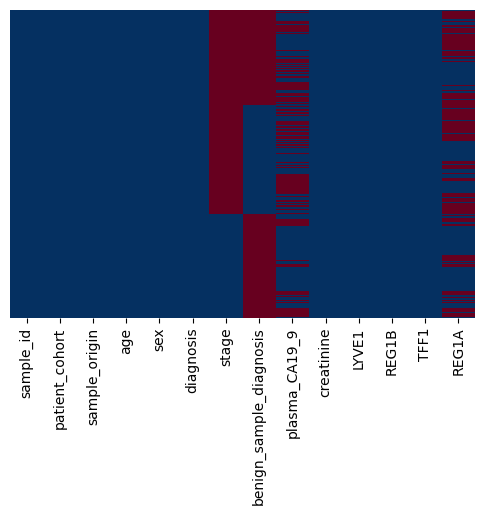

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='RdBu_r'); #rainbow

We mentioned before thar 4 features contain missing data. The stage and benign_sample_diagnosis features just confirm the pressence or absence of pancreatic cancer, and we will not use them.

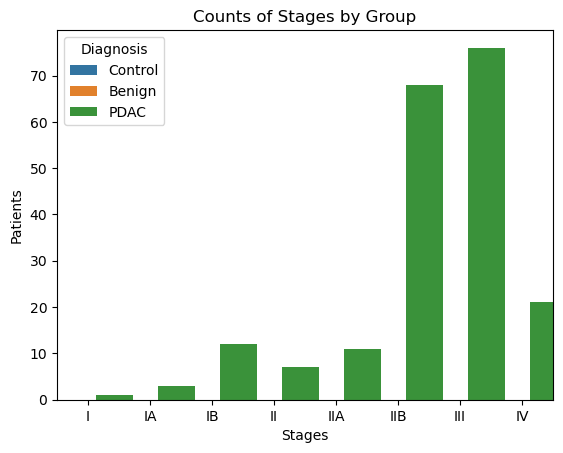

In [11]:
# Count the occurrences of each group
stage_counts = data['stage'].value_counts().sort_index()
stage_order = ['I', 'IA', 'IB', 'II', 'IIA', 'IIB', 'III', 'IV']
data['stage'] = pd.Categorical(data['stage'], categories=stage_order, ordered=True)

sns.countplot(data=data, x='stage', hue='diagnosis')

ax = plt.gca()
bar_width = 0.6
for bar in ax.patches: bar.set_width(bar_width)

plt.xlabel('Stages')
plt.ylabel('Patients')
plt.title('Counts of Stages by Group')
plt.legend(title='Diagnosis', loc='upper left', labels=['Control', 'Benign', 'PDAC'])
plt.show()


'***stage***' will not contain a value where the diagnosis is a control or benign. We will not use this feature to make predictions.

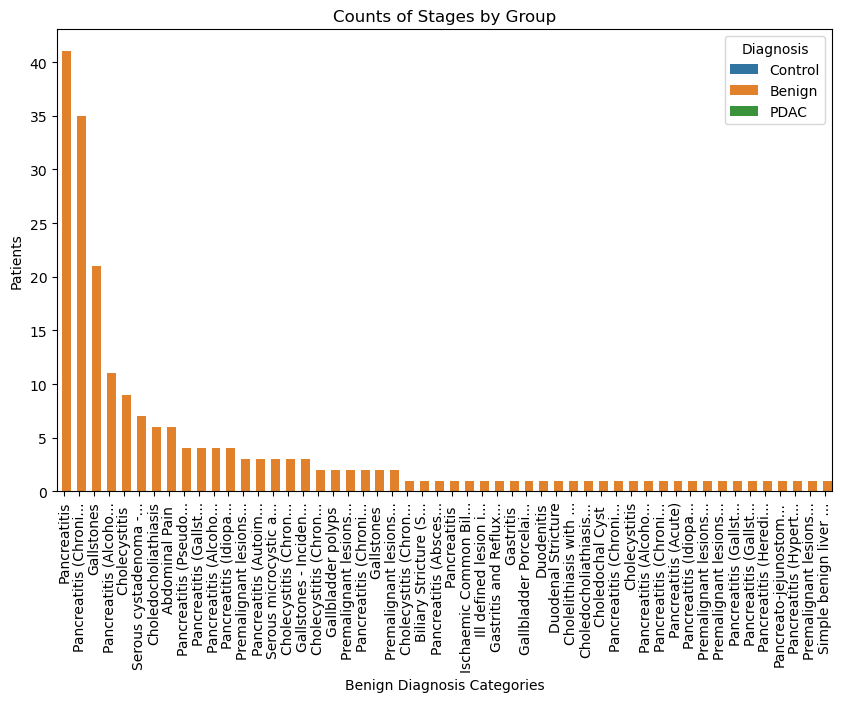

In [12]:
plt.figure(figsize=(10,6))

# Count the occurrences of each group
stage_counts = data['benign_sample_diagnosis'].value_counts().sort_values(ascending=False).index
benign_counts = pd.DataFrame({'benign_sample_diagnosis': data['benign_sample_diagnosis'].value_counts().index, 
                              'Counts': data['benign_sample_diagnosis'].value_counts().values})

sns.countplot(data=data, x='benign_sample_diagnosis', hue='diagnosis', order=stage_counts)

plt.xticks(rotation=90, ha='center')
ax = plt.gca()
bar_width = 0.6
for bar in ax.patches:
    bar.set_width(bar_width)
xticklabels = [label.get_text()[:20] + '...' if len(label.get_text()) > 20 else label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)

plt.xlabel('Benign Diagnosis Categories')
plt.ylabel('Patients')
plt.title('Counts of Stages by Group')
plt.legend(title='Diagnosis', loc='upper right', labels=['Control', 'Benign', 'PDAC'])
plt.show()


'**benign_sample_diagnosis**' contains a diagnosis for each case where the condition is benign. We also will not use this feature.

One of the pancreatic cancer biomarkers, **plasma_CA19_9**, is currently the most widely used biomarker for pancreatic cancer detection, however, this method is affected by low precision and recall. Other benign diagnoses show elevated levels of **plasma_CA19_9**, resulting in the increase of false positive predictions. In some other cases, the pancreatic cancer patient will not have an elevated level of plasma_CA19_9, leading to a false negative prediction when relying on this method.

Nevertheless, **benign_sample_diagnosis** and **stage** values are specific to the presence or absence of a malignant prediction and they don't help us make pancreatic cancer predictions, so we will drop them.

In [13]:
data_filtered = data.drop(['sample_id', 'patient_cohort', 'sample_origin', 'stage', 'benign_sample_diagnosis'], axis=1)

Let's take a look at the other two features with missing values.

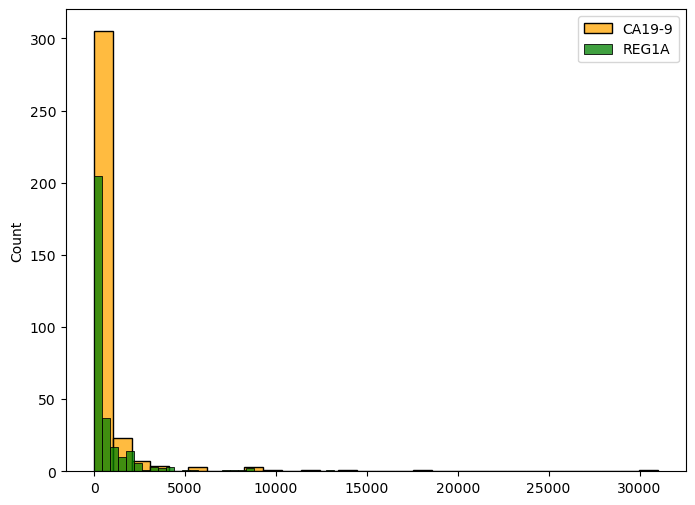

In [14]:
plt.figure(figsize=(8,6))

sns.histplot(data=data_filtered, x='plasma_CA19_9', bins=30, color='orange', label='CA19-9')
sns.histplot(data=data_filtered, x='REG1A', bins=30, color='green', label='REG1A')

plt.xlabel('')
plt.legend()
plt.show()


Since the data are skewed, we will need to fill the missing values with the median.

In [15]:
cols = ['plasma_CA19_9', 'REG1A']
for col in cols:
    #df[col] = df[col].fillna(df.groupby('age')[col].mean()) #or std()
    data_filtered[col] = data_filtered[col].fillna(data_filtered[col].median())    # or std()

"""
CA19_9_median = data_filtered['plasma_CA19_9'].median()  #or std()
data_filtered['plasma_CA19_9'] = data_filtered['plasma_CA19_9'].fillna(CA19_9_median)
REG1A_median = data_filtered['REG1A'].median()  #or std()
data_filtered['REG1A'] = data_filtered['REG1A'].fillna(REG1A_median)
"""

"\nCA19_9_median = data_filtered['plasma_CA19_9'].median()  #or std()\ndata_filtered['plasma_CA19_9'] = data_filtered['plasma_CA19_9'].fillna(CA19_9_median)\nREG1A_median = data_filtered['REG1A'].median()  #or std()\ndata_filtered['REG1A'] = data_filtered['REG1A'].fillna(REG1A_median)\n"

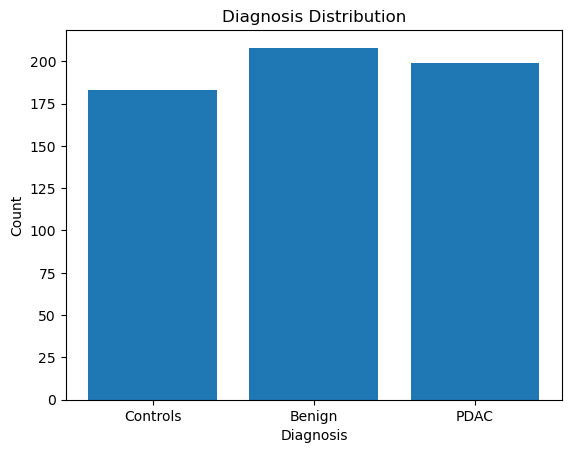

In [16]:
diagnosis_counts = data_filtered['diagnosis'].value_counts()
diagnosis_labels = diagnosis_counts.index.tolist()

plt.bar(diagnosis_labels, diagnosis_counts)#, color='#009FBD')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Diagnosis Distribution')
plt.xticks([1, 2, 3], ['Controls', 'Benign', 'PDAC'])
plt.show()

The three available classes are balanced; we don't need to deal with class imbalance. But let's test for statistical significance using a Chi-squared goodness-of-fit test to compare observed class frequencies with expected frequencies under the assumption of equal representation.

In [17]:
# Define the expected counts under the assumption of equal representation
total_records = diagnosis_counts[1] + diagnosis_counts[2] + diagnosis_counts[3]
expected_count = total_records / 3

observed = [diagnosis_counts[1], diagnosis_counts[2], diagnosis_counts[3]]

expected = [expected_count, expected_count, expected_count]

chi2, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

print('Chi-squared:', round(chi2, 2))
print('P-value:', round(p_value, 8))


Chi-squared: 1.63
P-value: 0.44252681


If we stratify the data by sex, do we see any difference between the diagnoses?

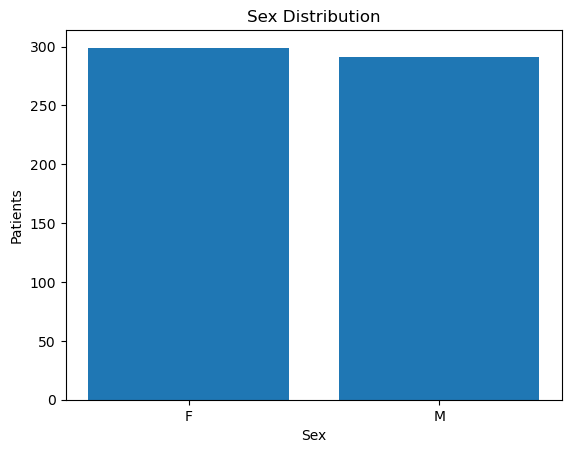

In [18]:
gender_counts = data_filtered['sex'].value_counts()
gender_labels = gender_counts.index.tolist()

plt.bar(gender_labels, gender_counts)#, color='#009FBD')
plt.xlabel('Sex')
plt.ylabel('Patients')
plt.title('Sex Distribution')
#plt.xticks([1, 2], ['Female', 'Male'])
plt.show()

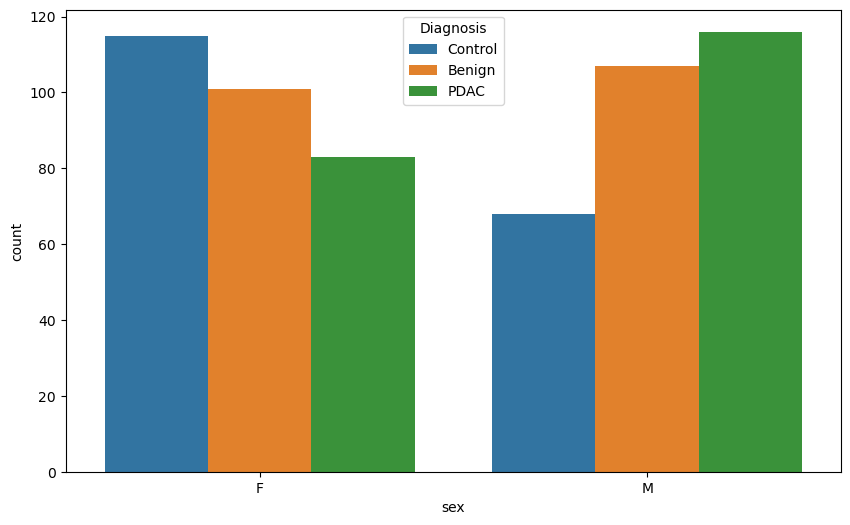

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(x='sex', data=data_filtered, hue='diagnosis', palette='tab10')

plt.legend(title='Diagnosis', loc='upper center', labels=['Control', 'Benign', 'PDAC'])
plt.show()

This dataset contains an excess of male individuals diagnosed with PDAC compared to women.

Let's now look at the 'age' feature:

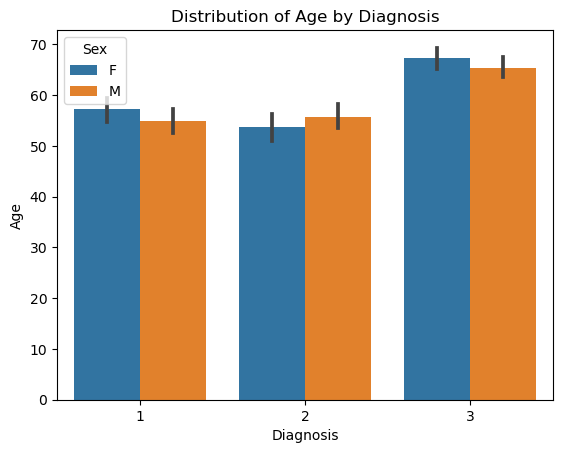

In [20]:
sns.barplot(data=data_filtered, x='diagnosis', y='age', hue='sex')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.title('Distribution of Age by Diagnosis')
plt.legend(title='Sex', loc='upper left')
plt.show()

In [21]:
age = data_filtered['age']
print('Minimum age: {}\nMaximum age: {}\nMedian age: {}'.format(age.min(),age.max(),age.median()))

Minimum age: 26
Maximum age: 89
Median age: 60.0


We will need to cluster the ages into age groups.

In [22]:
# Group the ages evenly and create 'mean_age' values
num_groups = 8
quantiles = np.linspace(0, 100, num_groups + 1)
age_limits = np.percentile(data_filtered['age'], quantiles)

age_labels = [f'{int(age_limits[i])}-{int(age_limits[i + 1] - 1)}' for i in range(num_groups)]
age_groups = pd.cut(data_filtered['age'], bins=age_limits, labels=age_labels, include_lowest=True)

def calculate_mean_age(age_group):
    lower, upper = age_group.split('-')
    lower = int(lower)
    upper = int(upper)
    return (lower + upper) / 2

data_filtered['mean_age'] = age_groups.apply(calculate_mean_age)
data_filtered['mean_age'] = data_filtered['mean_age'].astype('int')

data_filtered.drop('age', axis=1, inplace=True)



Finally we need to encode the 'sex' feature.

In [23]:
# Use One-Hot Encoding
#data_filtered = pd.get_dummies(data_filtered, columns=['sex'], prefix=['sex'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_filtered['sex'] = le.fit_transform(data_filtered['sex'])


<div style="background-color: #800080; padding: 10px;">IDENTIFYING OUTLIERS</div>

We will now check for outlier values in the biomarker features that could contribute to skewness in the data.

There are many methods that we can use to identify the pressence of outliers.

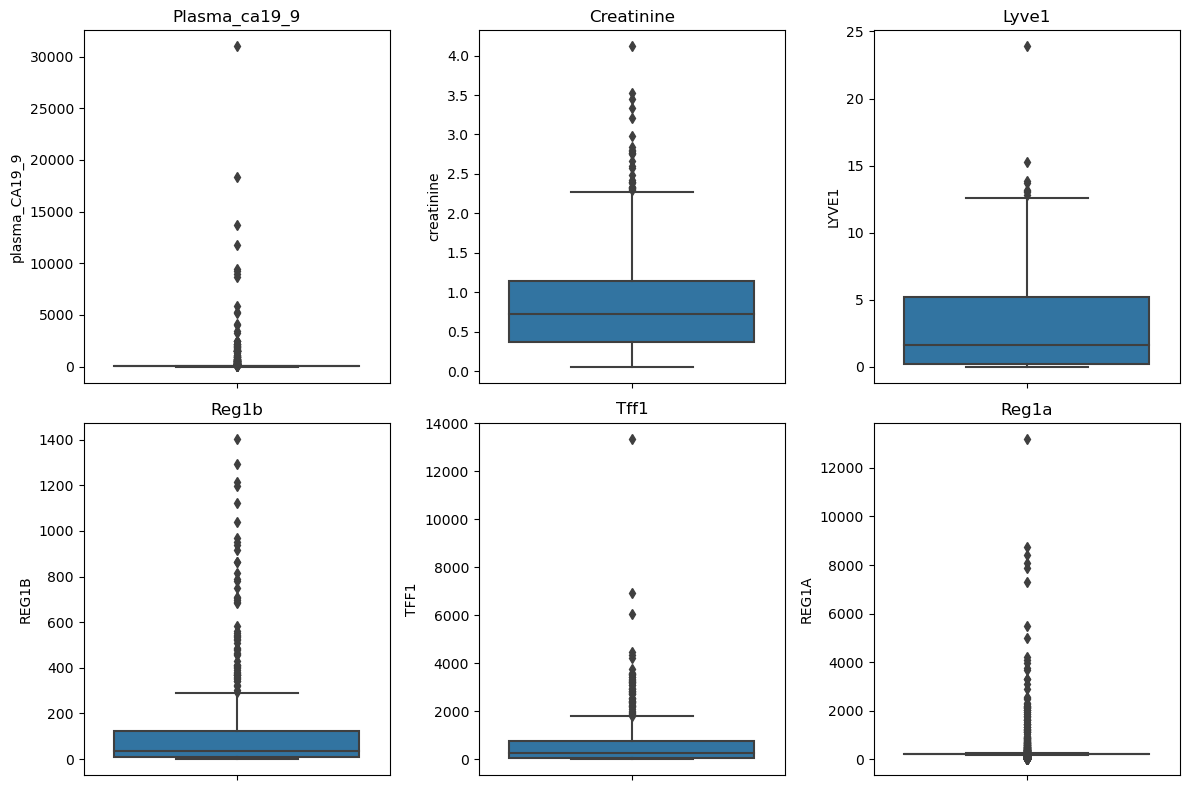

In [24]:
biomarkers = ['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, biomarker in enumerate(biomarkers):
    row = i // 3
    col = i % 3
    
    sns.boxplot(y=data_filtered[biomarker], ax=axs[row, col])
    axs[row, col].set_title(biomarker.capitalize())

#fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()

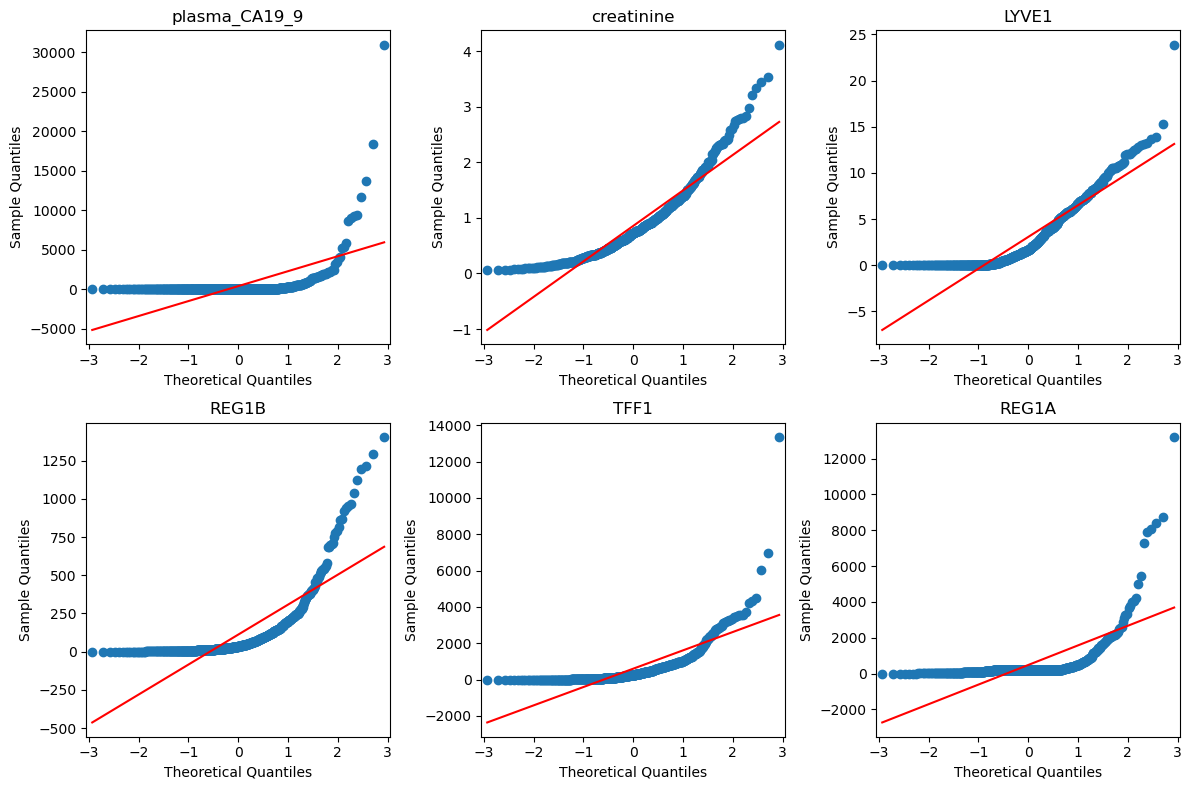

In [25]:
import statsmodels.api as sm
# Q-Q plots to compare to the quantiles to an expected normal distribution.
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, biomarker in enumerate(biomarkers):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sm.qqplot(data_filtered[biomarker], line='s', ax=ax)
    ax.set_title(biomarker)
    
plt.tight_layout()
plt.show()


In [26]:
# Measure how many standard deviations a data point is from the mean.
for biomarker in biomarkers:
    z_scores = stats.zscore(data_filtered[biomarker])
    outliers = (z_scores > 3) | (z_scores < -3)
    if outliers.any():
        print(f'{biomarker} contains outliers.')
    else:
        print(f'{biomarker} does not contain outliers.')
    
#for biomarker in biomarkers:
    #z_scores = np.abs((data[biomarker] - data[biomarker].mean()) / data[biomarker].std())
    #threshold = 2
    #outliers = data[z_scores > threshold]
    # Remove outliers from the DataFrame
    #data = data[z_scores <= threshold]
    # Transformation on the data
    #data[biomarker] = np.sqrt(data[variable]) #transformed_data = np.log(data)


plasma_CA19_9 contains outliers.
creatinine contains outliers.
LYVE1 contains outliers.
REG1B contains outliers.
TFF1 contains outliers.
REG1A contains outliers.


In [27]:
# Measure the difference between Q3 and Q1. 
# Outlier data points fall at < Q1 - 1.5 * IQR or > Q3 + 1.5 * IQR.
for biomarker in biomarkers:
    Q1 = data_filtered[biomarker].quantile(0.25)
    Q3 = data_filtered[biomarker].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (data_filtered[biomarker] < Q1 - 1.5 * IQR) | (data_filtered[biomarker] > Q3 + 1.5 * IQR)
    
    if outliers.any():
        print(f'{biomarker} contains outliers.')
    else:
        print(f'{biomarker} does not contain outliers.')

plasma_CA19_9 contains outliers.
creatinine contains outliers.
LYVE1 contains outliers.
REG1B contains outliers.
TFF1 contains outliers.
REG1A contains outliers.


In [28]:
from sklearn.ensemble import IsolationForest

for biomarker in biomarkers:
    model = IsolationForest(contamination=0.05)
    feature = data_filtered[biomarker].values.reshape(-1, 1)
    model.fit(feature)
    outliers = model.predict(feature)
    if outliers.any():
        print(f'{biomarker} contains outliers.')
    else:
        print(f'{biomarker} does not contain outliers.')

plasma_CA19_9 contains outliers.
creatinine contains outliers.
LYVE1 contains outliers.
REG1B contains outliers.
TFF1 contains outliers.
REG1A contains outliers.


In [29]:
from sklearn.svm import OneClassSVM

for biomarker in biomarkers:
    model = OneClassSVM(nu=0.05)
    feature = data_filtered[biomarker].values.reshape(-1, 1)
    model.fit(feature)
    outliers = model.predict(feature)
    if outliers.any():
        print(f'{biomarker} contains outliers.')
    else:
        print(f'{biomarker} does not contain outliers.')

plasma_CA19_9 contains outliers.
creatinine contains outliers.
LYVE1 contains outliers.
REG1B contains outliers.
TFF1 contains outliers.
REG1A contains outliers.


In [30]:
for biomarker in biomarkers:
    print(data_filtered[biomarker].min())

0.0
0.05655
0.00012943
0.001104422
0.00529308
0.0


All the biomarkers contain outliers. These features contain 0's, but not negative values.

Let's look at the structure of the data.

<div style="background-color: #800080; padding: 10px;">DATA SKEWNESS</div>

Now we will check the distribution of the values in each of the features.

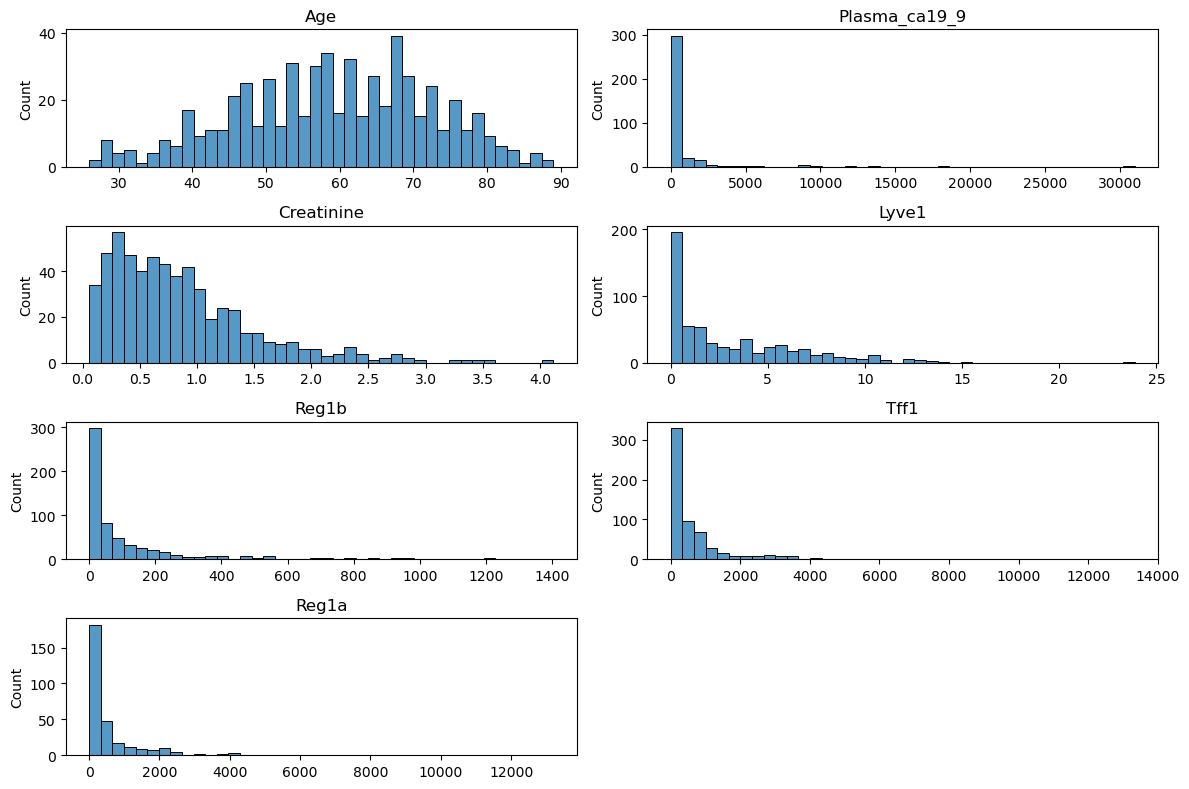

In [31]:
age_plus_biomarkers = ['age'] + biomarkers

rows = 4
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for i, biomarker in enumerate(age_plus_biomarkers):
    row = i // 2
    col = i % 2
    
    sns.histplot(data[biomarker], bins=40, ax=axs[row, col])
    axs[row, col].set_title(biomarker.capitalize())
    axs[row, col].set_xlabel('')

# Remove unused subplots
for i in range(rows * cols):
    if i >= len(age_plus_biomarkers):
        fig.delaxes(axs[i // cols, i % cols])

plt.tight_layout()
plt.show()

Only 'age' is not skewed.

We will not remove outliers. Since the data are right-skewed, we will use a log transformation to make the data more symmetric and reduce the impact of extreme values.

In [32]:
#data_sqrt = data_filtered.copy()
data_log = data_filtered.copy()

for biomarker in biomarkers:
    #data_sqrt[biomarker] = np.sqrt(data_filtered[biomarker]) 
    # Add a constant to remove zeros
    constant = 1
    data_log[biomarker]  = data_log[biomarker] + constant

    data_log[biomarker] = np.log(data_log[biomarker])
    

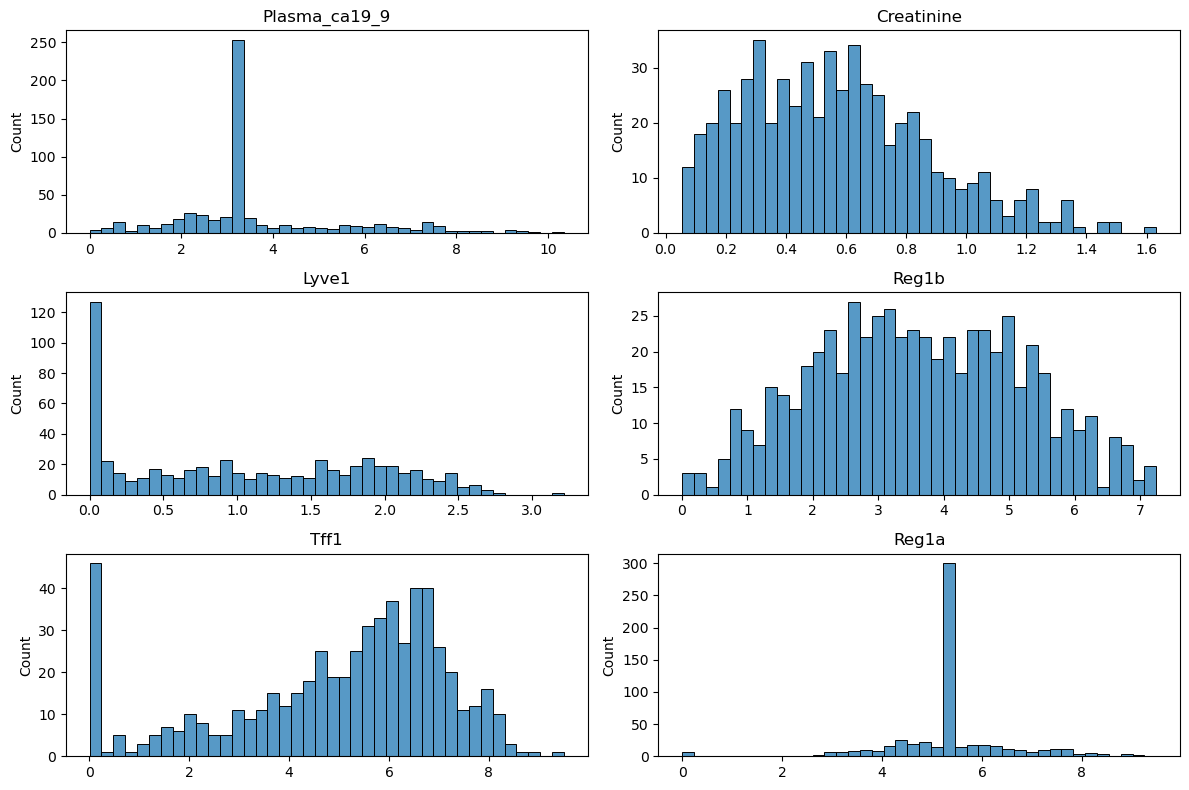

In [33]:
age_plus_biomarkers = biomarkers

rows = 3
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for i, biomarker in enumerate(age_plus_biomarkers):
    row = i // 2
    col = i % 2
    
    sns.histplot(data_log[biomarker], bins=40, ax=axs[row, col])
    axs[row, col].set_title(biomarker.capitalize())
    axs[row, col].set_xlabel('')

# Remove unused subplots
for i in range(rows * cols):
    if i >= len(age_plus_biomarkers):
        fig.delaxes(axs[i // cols, i % cols])

plt.tight_layout()
plt.show()

Now the data look a bit more normally distributed than before, but there is still some skewness.

In [34]:
numeric_columns = data_log.select_dtypes(include=np.number)

skewness = stats.skew(numeric_columns)
print('Skewness:', skewness)


Skewness: [ 0.02712114 -0.04906092  1.05282031  0.59567917  0.18649248  0.04489053
 -0.83407532 -0.50359187 -0.09699178]


Skewness: [ 0.02712114 -0.04906092 10.34969465  1.46268247  1.39046698  3.32544339
  5.1451789   6.30105626 -0.09699178]


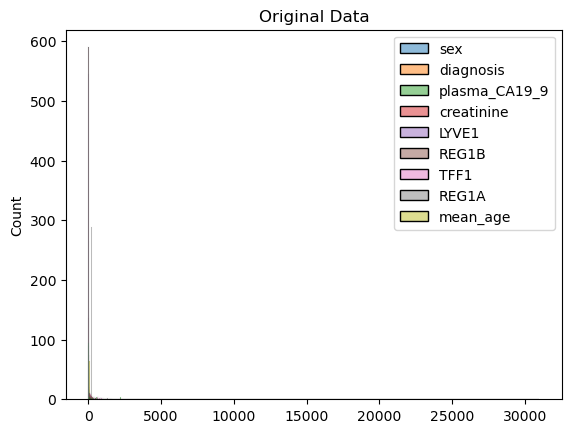

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


Transformed Skewness: [        nan -0.38236477         nan -0.45653298 -1.1288431  -0.69746808
 -1.58723301         nan -0.5756425 ]


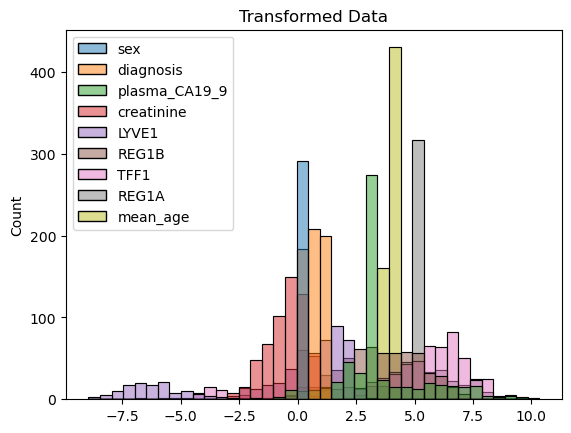

In [35]:
# PLOT SKEWNESS
numeric_columns = data_filtered.select_dtypes(include=np.number)

skewness = stats.skew(numeric_columns)
print('Skewness:', skewness)

sns.histplot(numeric_columns)
plt.title('Original Data')
plt.show()

# Logarithmic transformation
transformed_data = np.log(numeric_columns)

# Calculate the skewness of the transformed data
transformed_skewness = stats.skew(transformed_data)
print('Transformed Skewness:', transformed_skewness)

sns.histplot(transformed_data)
plt.title('Transformed Data')
plt.show()

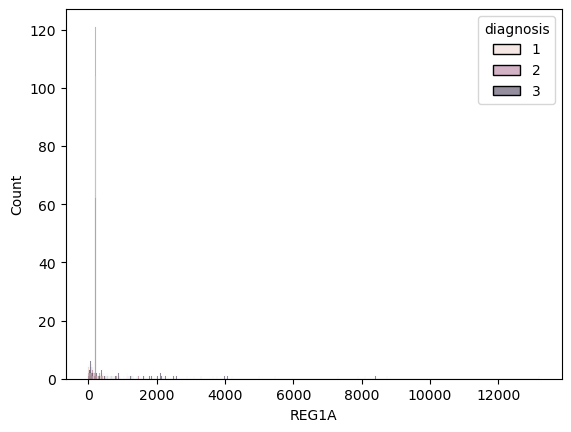

In [39]:
sns.histplot(x='REG1A', data=data_filtered, hue='diagnosis');

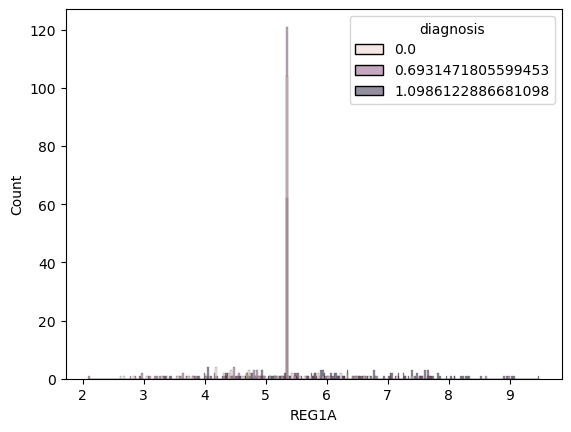

In [40]:
sns.histplot(x='REG1A', data=transformed_data, hue='diagnosis');

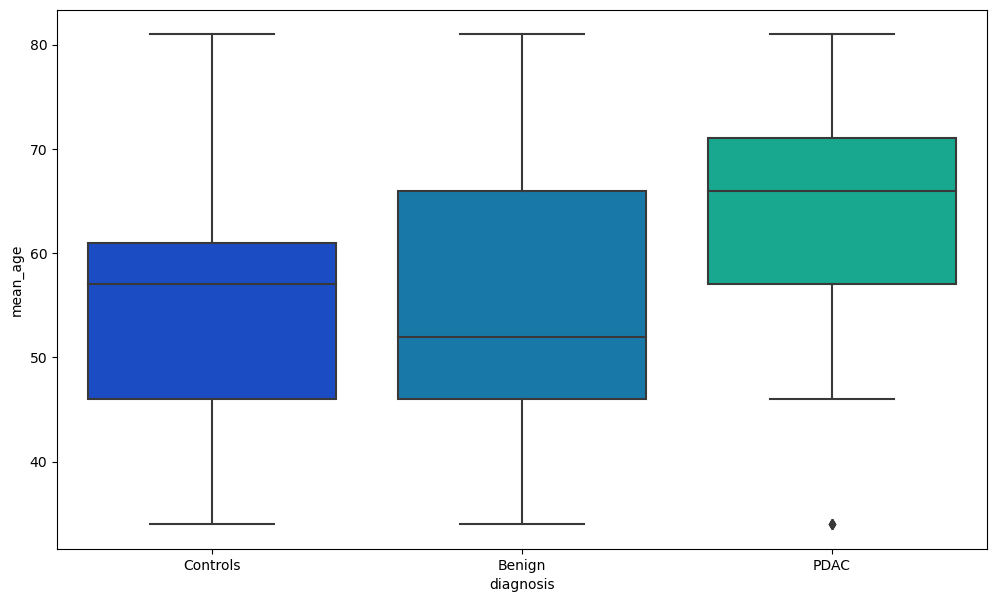

In [41]:
plt.figure(figsize=(12, 7))
diagnosis_mapping = {1: 'Controls', 2: 'Benign', 3: 'PDAC'}
diagnostic_age=data_filtered.copy()
diagnostic_age['diagnosis'] = data_filtered['diagnosis'].map(diagnosis_mapping)
sns.boxplot(y='mean_age', x='diagnosis', data=diagnostic_age, palette='winter');

What is the correlation between the target and features?

In [42]:
corr = data_log.corr().diagnosis.sort_values(ascending = False)
corr

diagnosis        1.000000
plasma_CA19_9    0.605798
LYVE1            0.577502
TFF1             0.474897
REG1B            0.435495
mean_age         0.316382
REG1A            0.273476
sex              0.169081
creatinine       0.064350
Name: diagnosis, dtype: float64

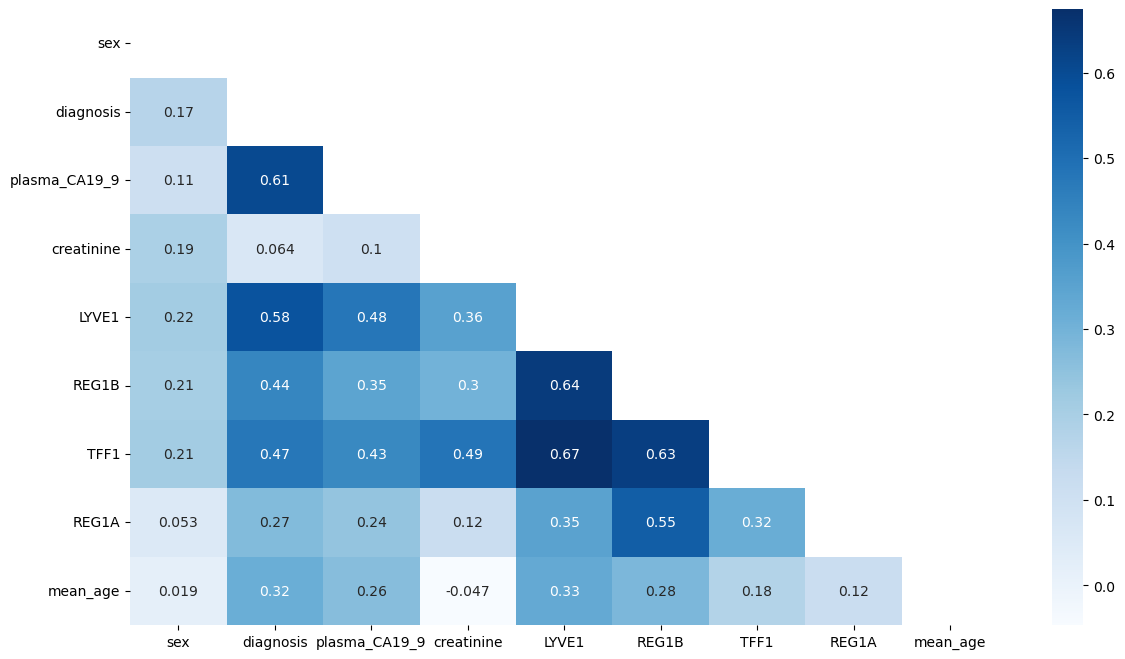

In [43]:
plt.figure(figsize=(14,8))
mask=np.triu(data_log.corr())
sns.heatmap(data_log.corr(),mask=mask, annot=True, cmap='Blues')
plt.show()

<div style="background-color: #800080; padding: 10px;">MODELS, PREDICTIONS, CROSS VALIDATION</div>

In [44]:
def models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    algorithms = [
        ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('Extra Trees', ExtraTreesClassifier(n_estimators=200, n_jobs=1, random_state=42,
                                             max_depth=20, min_samples_split=10, min_weight_fraction_leaf =0.0)),
        ('XGBoost', XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', 
                                  num_class=3, random_state=42))
    ]

    results = {}
    f_importance = pd.DataFrame({'Feature':X.columns})
    for name, model in algorithms:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)    # model.score(X_test, y_test)*100
        report = classification_report(y_test, y_pred)
        results[name] = accuracy
        f_importance = f_importance.merge(pd.DataFrame({f'{name}':model.feature_importances_, 'Feature':X.columns}), on='Feature')
    return accuracy, report, results, f_importance

In [45]:
X = data_log.drop('diagnosis', axis=1)
y = data_log['diagnosis']

In [46]:
# ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]
# This is causing a mismatch with the expected classes for the sparse_categorical_crossentropy loss function
y = y - 1

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

algorithms = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(n_estimators=200, n_jobs=1, random_state=42,
                                         max_depth=20, min_samples_split=10, min_weight_fraction_leaf =0.0)),
    ("XGBoost", XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', 
                              num_class=3, random_state=42))
]

results = {}
f_importance = pd.DataFrame({'Feature':X.columns})
for name, model in algorithms:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)    # model.score(X_test, y_test)*100
    report = classification_report(y_test, y_pred)
    results[name] = accuracy
    f_importance = f_importance.merge(pd.DataFrame({f'{name}':model.feature_importances_, 'Feature':X.columns}), on='Feature')

for name, accuracy in results.items():
    print(f'{name} Accuracy: {accuracy:.2f}')
    print('Classification Report:\n', report)


Random Forest Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77        62
           1       0.68      0.71      0.70        63
           2       0.85      0.87      0.86        52

    accuracy                           0.77       177
   macro avg       0.77      0.77      0.77       177
weighted avg       0.77      0.77      0.77       177

Extra Trees Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77        62
           1       0.68      0.71      0.70        63
           2       0.85      0.87      0.86        52

    accuracy                           0.77       177
   macro avg       0.77      0.77      0.77       177
weighted avg       0.77      0.77      0.77       177

XGBoost Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.7

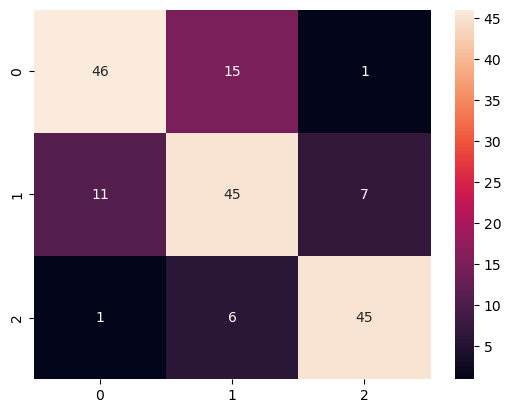

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

Let's check which feature is more important for our predictions.

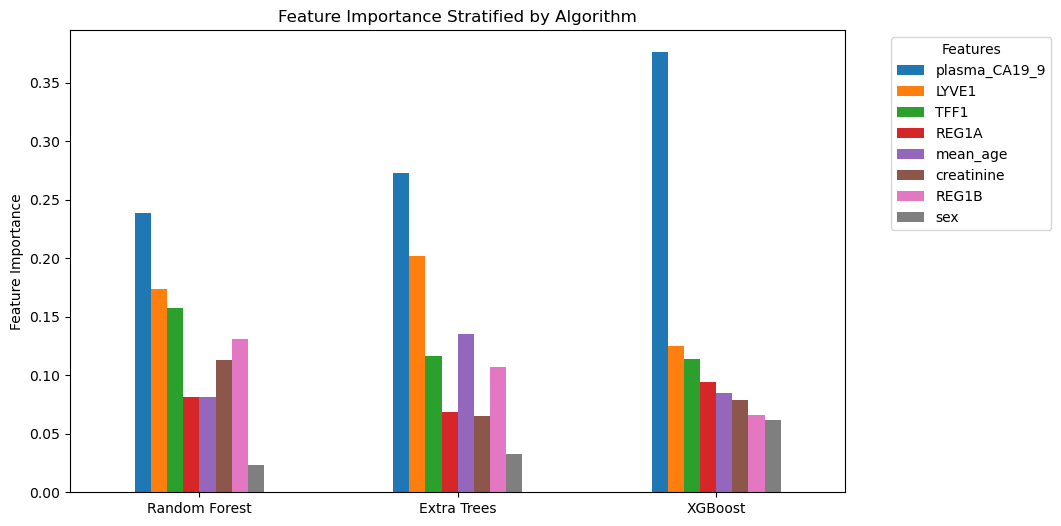

In [50]:
f_importance.set_index('Feature', inplace=True)
f_importance = f_importance.sort_values(by='XGBoost', ascending=False)

f_importance = f_importance.T

ax = f_importance.plot(kind='bar', figsize=(10,6), rot=0)    # f_importance.plot.bar(rot=40);
plt.title('Feature Importance Stratified by Algorithm')
plt.xlabel('')
plt.ylabel('Feature Importance')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

As expected, CA19_9 carries the highest predictive importance. Sex has the lowest predictive importance consistently across all three algorighms, but in XGBoost it matches the predictive value of REG1B.

Let's see where the biomarker values fall above the average value in each diagnosis group.

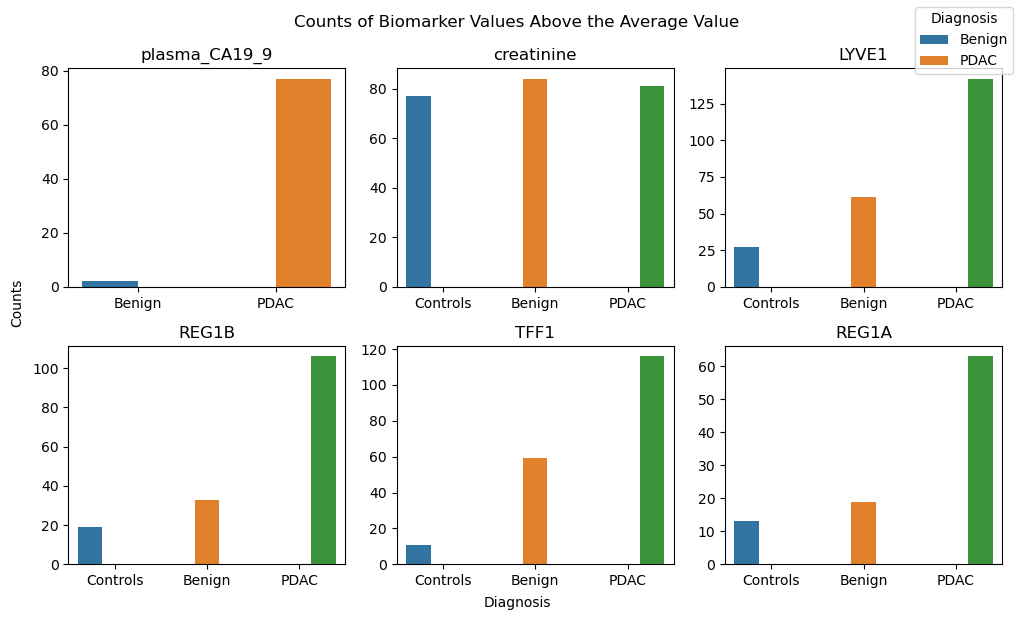

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mapping of diagnosis numbers to names
diagnosis_mapping = {1: 'Controls', 2: 'Benign', 3: 'PDAC'}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, biomarker in enumerate(biomarkers):
    above_avg = data_filtered[data_filtered[biomarker] >= data_filtered[biomarker].mean()]
    above_mean = above_avg.copy()
    
    above_mean['diagnosis'] = above_mean['diagnosis'].map(diagnosis_mapping)
    
    sns.countplot(data=above_mean, x='diagnosis', hue='diagnosis', ax=axes[i])
    axes[i].set_title(f'{biomarker}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].get_legend().remove()  # Remove default legend

fig.suptitle('Counts of Biomarker Values Above the Average Value')
fig.text(0.5, 0.00, 'Diagnosis', ha='center', va='center')
fig.text(0.00, 0.5, 'Counts', ha='center', va='center', rotation='vertical')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Diagnosis', loc='upper right')

plt.tight_layout()
plt.show()

Creatinine levels are always high across all diagnosis. Is this feature affecting lowering the accuracy of our model?

<div style="background-color: #800080; padding: 10px;">CONCLUSIONS</div>

CA19_9 has the most predictive importance across all the algorithms used, followed by LYVE1.

We evaluated three different algorithms to test the accuracy of the model: 
- XGBoost hand an accuracy of 0.77
- Random Forest had an accuracy: 0.76
- Extra Trees had an accuracy of 0.71

While the predictive potential of the model is moderate, we need to evaluate if this is being affected by a need for better data processing or if the these biomarkers alone carry a limitation in the capacity to make accurate predictions. Also, a new study used SNP-level deta associated with the synthesis of CA19–9 synthesis (Dbouk et al. 2023: https://doi.org/10.1158/1078-0432.CCR-23-0655).

Next, I will evaluate the predictive power of this model to detect pancreatic cancer at different stages of the disease.